a = 7 is valid as gcd(7,15)=1


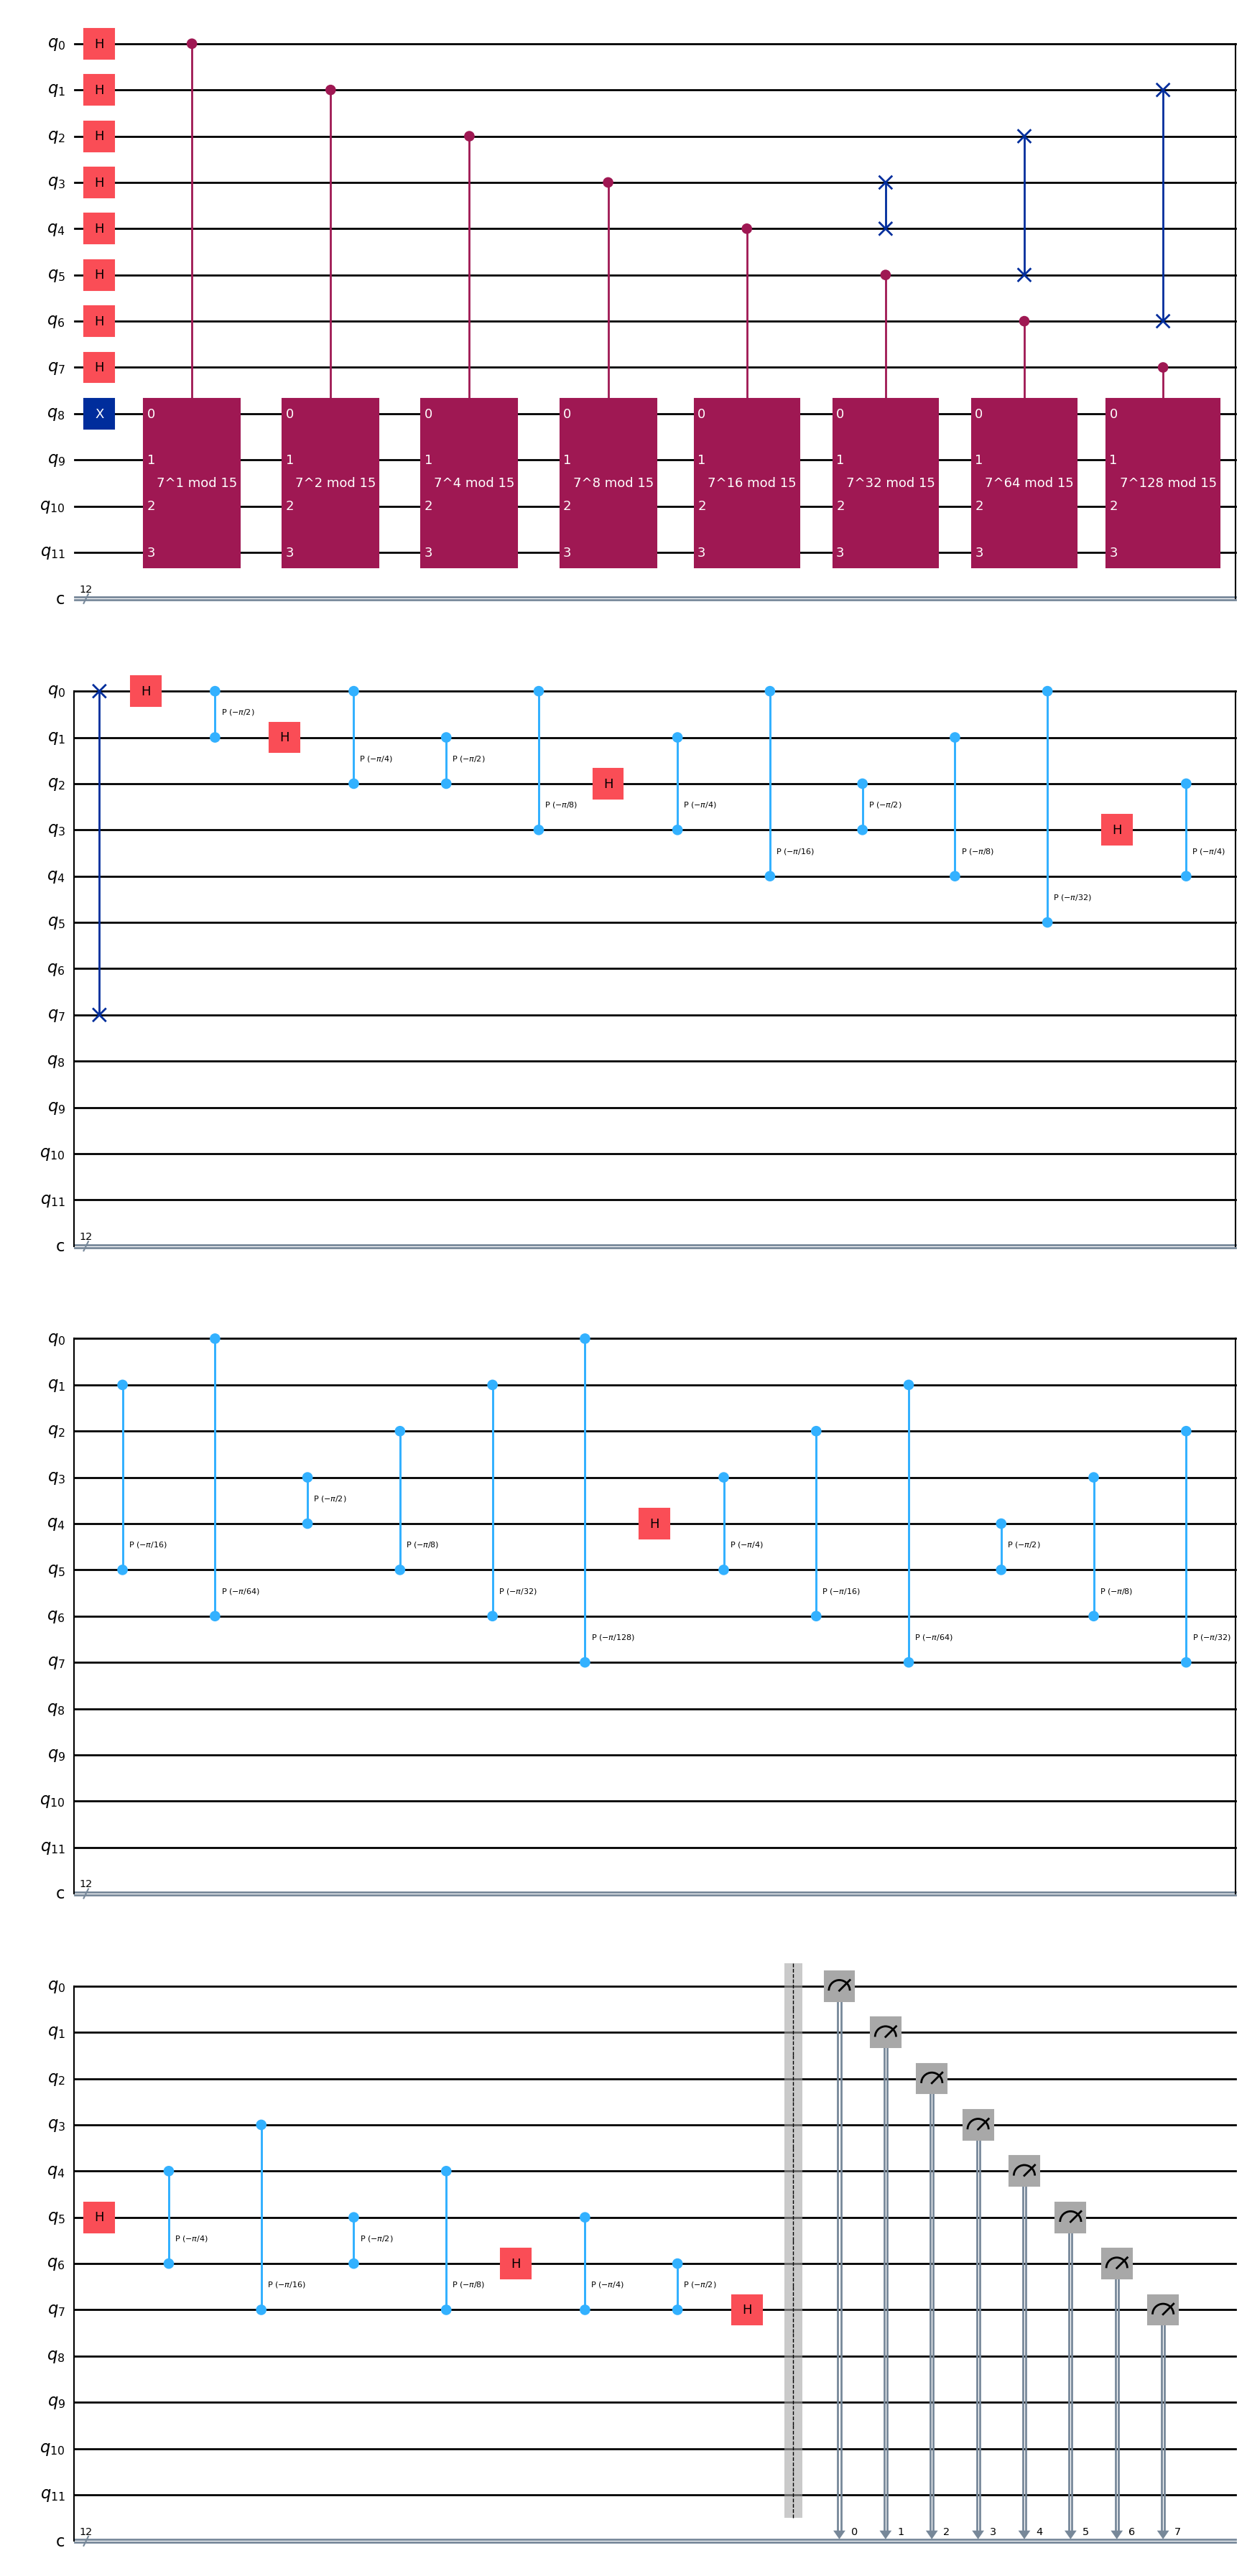

In [312]:
import numpy as np
from math import gcd
from fractions import Fraction
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

N = 15
a = 7  # Chosen such that gcd(a, N) = 1

if gcd(a, N) != 1:
    print(f"One factor found: {gcd(a, N)}")
else:
    print(f"a = {a} is valid as gcd({a},{N})=1")


n = 8
qc = QuantumCircuit(n+4, n+4)


for q in range(n):
    qc.h(q)                    # Apply Hadamard gates to counting qubits


qc.x(n)                       # Set last qubit to |1⟩ 

# Define controlled modular multiplication gates : (borrowed)

def c_amod15(a, power):
    U = QuantumCircuit(4)
    for i in range(power % 4):
        if a in [2, 7, 8, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        elif a == 4:
            U.swap(0, 2)
            U.swap(1, 3)
        elif a == 11:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        else:
            pass
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    return U.control()

for j in range(n):
    qc.append(c_amod15(a, 2**j), [j] + [i + n for i in range(4)])


# Applying inverse QFT
def IQFT(qc, qubits):
    n = len(qubits)
    for i in range(n // 2):
        qc.swap(qubits[i], qubits[n - i - 1])
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), qubits[m], qubits[j])
        qc.h(qubits[j])

IQFT(qc, list(range(n)))

qc.barrier()

qc.measure(range(n), range(n))
qc.draw("mpl");

In [313]:

from qiskit import transpile
from qiskit_aer import AerSimulator
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result=simulator.run(compiled_circuit, shots=4096).result()
counts = result.get_counts()
print("Measurement Results:", counts)


Measurement Results: {'000011000000': 1030, '000001000000': 1031, '000000000000': 1010, '000010000000': 1025}


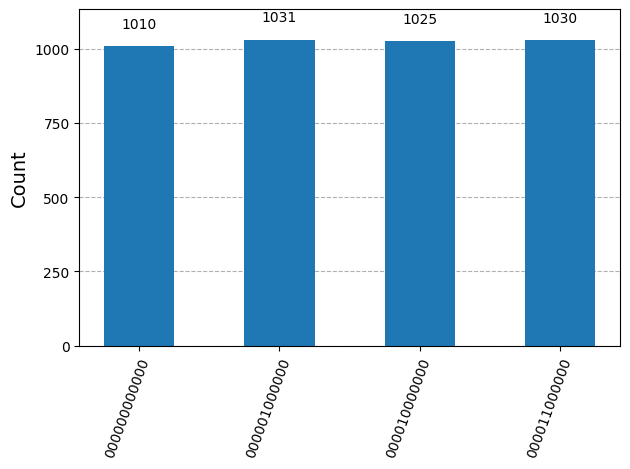

In [314]:
%matplotlib inline
plot_histogram(counts)
plt.show();


In [315]:
# measuring most frequent output in binary
output = max(counts, key=counts.get)
print(f"Most frequent measurement: {output} ")

# converting it to decimal
max_output = int(output, 2)
print(max_output)

#calculating phase
phase = max_output/2**n
print(f"phase = {phase}")

# clculating period r

r = Fraction(phase).limit_denominator(N).denominator
print(f"period r = {r}")

if gcd(a, N) != 1:
    print(f"One factor found: {gcd(a, N)}")

if r % 2 != 0:
    print("Invalid period, try again.")
else:
    factor1 = gcd(pow(a, r//2) - 1, N)
    factor2 = gcd(pow(a, r//2) + 1, N)
    print(f"factors of {N}: {factor1}, {factor2}")


Most frequent measurement: 000001000000 
64
phase = 0.25
period r = 4
factors of 15: 3, 5
